# Identify running epochs

## Set-up

In [1]:
# imports
import numpy as np
from os import listdir
import matplotlib.pyplot as plt

In [2]:
#Settings
PROJECT_PATH = 'G:/Shared drives/visual_encoding'
MANIFEST_PATH = 'D:/datasets/allen_vc'

FS = 2500 # sampling rate

THRESHOLD = 5 # velocity
MIN_DURATION = 1 # seconds
TIME2PLOT = 180 # seconds

In [13]:
# functions

def find_segments(signal, threshold, return_below=False):
    """
    Find segments of a signal that are above/below a threshold.
    
    Parameters
    ----------
        signal : array-like
            The signal to search for segments.
        threshold : float
            Threshold value to search for segments.
        return_below : bool, optional
            If True, return segments below threshold. Default is False.
            
    Returns
    -------
        epoch_times : array-like
            Start and end times of segments.
    """

    # get indices of segments above threshold
    above_threshold = np.where(signal > threshold)[0]
    if len(above_threshold) == 0:
        return np.array([])

    # get start and end of segments
    starts = above_threshold[np.where(np.diff(above_threshold) != 1)[0] + 1]
    ends = above_threshold[np.where(np.diff(above_threshold) != 1)[0]]

    # add first and last index if needed
    if starts[0] > ends[0]:
        starts = np.insert(starts, 0, 0)
    if ends[-1] < starts[-1]:
        ends = np.append(ends, len(signal)-1)

    # join epoch times as array
    epoch_times = np.array([starts, ends]).T

    # print number of epochs dropped
    print(f'Identified {epoch_times.shape[0]} epochs')

    # return segments below threshold if requested
    if return_below:
        epochs_below = np.vstack([np.insert(epoch_times[:,1], 0, 0),
            np.insert(epoch_times[:,0], -1, -1)]).T

        return epoch_times, epochs_below

    else:
        return epoch_times

def plot_epochs(signal, time, epochs, threshold=None):
    """Plots a signal over time, with annotations for epochs.

    Parameters
    ----------
    signal : numpy array
        Signal to be plotted.
    time : numpy array
        Time stamps for the signal.
    epochs : 2D numpy array
        Epochs to annotate.
    threshold : float, optional
        Horizontal line at given value.

    Returns
    -------
    fig, ax : matplotlib Figure, Axes
        Figure and axes for the plot.
    """

    # plot signal
    fig, ax = plt.subplots(figsize=[20,4])
    ax.plot(time, signal)

    # annotate threshold
    if threshold is not None:
        ax.axhline(threshold, color='k')

    # annotate epochs
    for t_start in np.array(time[epochs[:,0]]):
        ax.axvline(t_start, color='b')
    for t_stop in np.array(time[epochs[:,1]]):
        ax.axvline(t_stop, color='r')

    return fig, ax

def join_epochs_with_gap(epochs, min_gap):
    """
    Joins together epochs that have a gap shorter than a given minimum duration between them.

    Parameters
    ----------
    epochs : numpy array
        Nx2 array containing start and end times of each epoch. 
    min_gap : float
        Minimum duration of gap between epochs.

    Returns
    -------
    epochs_clean : numpy array
        Nx2 array containing the start and end times of the remaining epochs.
    """

    epochs_clean = []
    for ii in range(epochs.shape[0] - 1):
        gap = epochs[ii+1, 0] - epochs[ii, 1]

        # if gap is less than the minimun duration
        if gap < min_gap:
            # treat first differenctly
            if epochs_clean==[]:
                epochs_clean.append([epochs[ii, 0], epochs[ii+1, 1]])
            else:
                # check previous entry
                if epochs_clean[-1][1] == epochs[ii, 1]:
                    epochs_clean[-1][1] = epochs[ii+1, 1]
                else:
                    epochs_clean.append([epochs[ii, 0], epochs[ii+1, 1]])

        # if gap is long enough
        else:
            # treat first differenctly
            if epochs_clean==[]:
                epochs_clean.append(epochs[ii])
            else:
                # check previous entry
                if epochs_clean[-1][1] == epochs[ii, 1]:
                    continue
                else:
                    epochs_clean.append(epochs[ii])

    epochs_clean = np.array(epochs_clean)

    # print number of epochs dropped
    print(f'Joined {epochs.shape[0] - epochs_clean.shape[0]} / {epochs.shape[0]} epochs')

    return epochs_clean

def drop_short_epochs(epochs, min_duration):
    """
    Drop epochs shorter than a given duration

    Parameters
    ----------
    epochs : ndarray
        2D array of epochs, of shape (n_epochs, 2).
    min_duration : float
        Minimum duration of epochs to keep.

    Returns
    -------
    epochs_clean : ndarray
        2D array of epochs, with epochs shorter than `min_duration` removed.
    """

    # get duration of epochs
    duration = np.ravel(np.diff(epochs, axis=1))

    # drop epochs below threshold
    epochs_clean = epochs[duration > min_duration]

    # print number of epochs dropped
    print(f'Dropped {epochs.shape[0] - epochs_clean.shape[0]} / {epochs.shape[0]} epochs')

    return epochs_clean

def get_inverse_epochs(epochs, signal):
    """
    Get inverse epochs from a given epoch array and signal.

    Parameters
    ----------
    epochs : array_like
        2-dimensional array of start and stop times of regular epochs.
    signal : array_like
        Signal array representing the signal being analyzed.

    Returns
    -------
    epochs_inv : array_like
        2-dimensional array of start and stop times of the inverse epochs.
    """

    # swap start and stop times
    # start_times = epochs[:,1]
    # stop_times = epochs[:,0]
    start_times = np.insert(epochs[:,1], 0, 0)
    stop_times = np.append(epochs[:,0], len(signal)-1)

    # if first epoch start on first time point, drop first stop time
    if epochs[0,0] == 0:
        start_times = start_times[1:]
        stop_times = stop_times[1:]

    # if last epoch ends on last time point
    if epochs[-1,1] == len(signal)-1:
        start_times = start_times[:-1]
        stop_times = stop_times[:-1]

    # combine epoch times
    epochs_inv = np.vstack([start_times, stop_times]).T

    return epochs_inv

## Main

In [4]:
# load example data
data_in = np.load(f"{PROJECT_PATH}/data/behavior/running/running_771160300_spont.npz")
velocity = data_in['velocity']
time = data_in['time']

#### Identify epochs above threshold

Identified 283 epochs


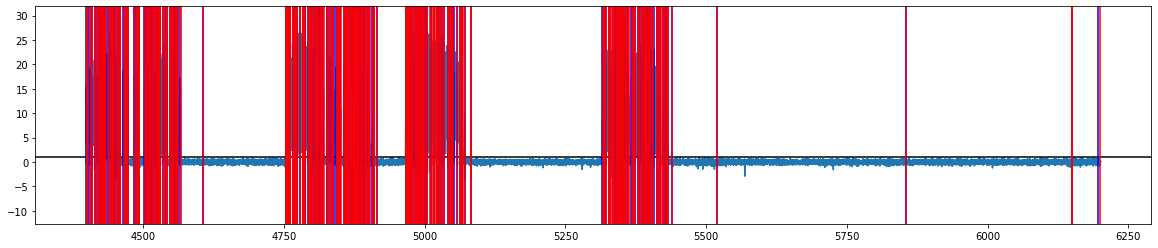

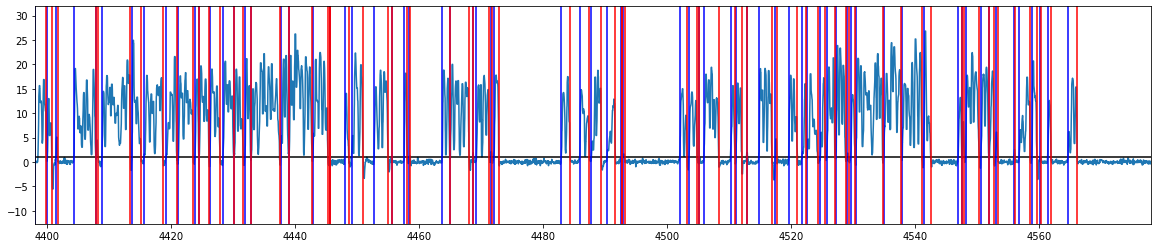

In [5]:
# id epochs above threshold
epochs = find_segments(velocity, threshold=1, return_below=False)

# plot results
plot_epochs(velocity, time, epochs, threshold=1)
fig, ax = plot_epochs(velocity, time, epochs, threshold=1)
ax.set_xlim([time[0], time[0]+TIME2PLOT]);

#### Join epochs separated by short gaps

Joined 235 / 283 epochs


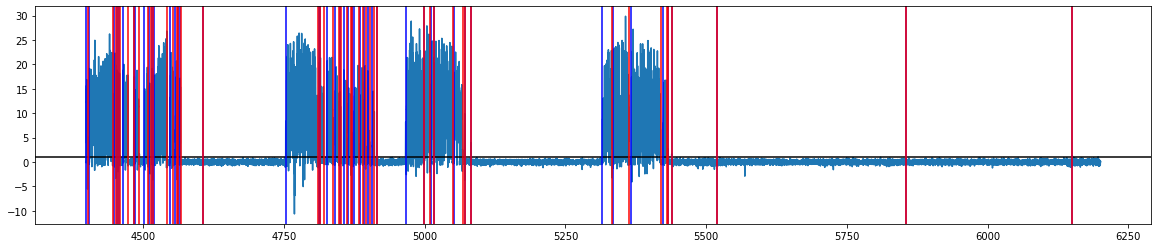

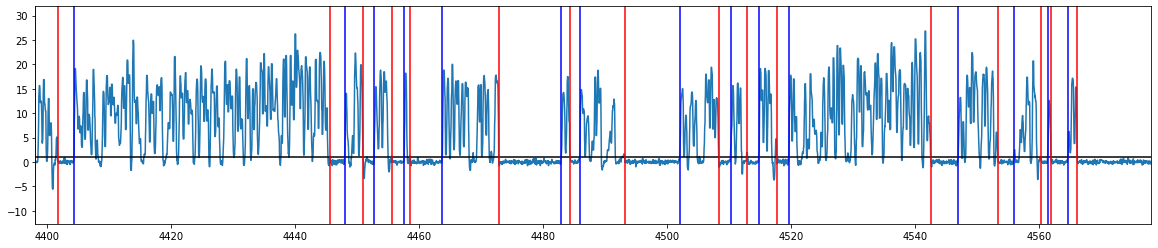

In [6]:
# join epochs
epochs_j = join_epochs_with_gap(epochs, min_gap=MIN_DURATION*FS)

# plot results
fig, ax = plot_epochs(velocity, time, epochs_j, threshold=1)
fig, ax = plot_epochs(velocity, time, epochs_j, threshold=1)
ax.set_xlim([time[0], time[0]+TIME2PLOT]);

#### Eliminate short-duration epochs

Dropped 13 / 48 epochs


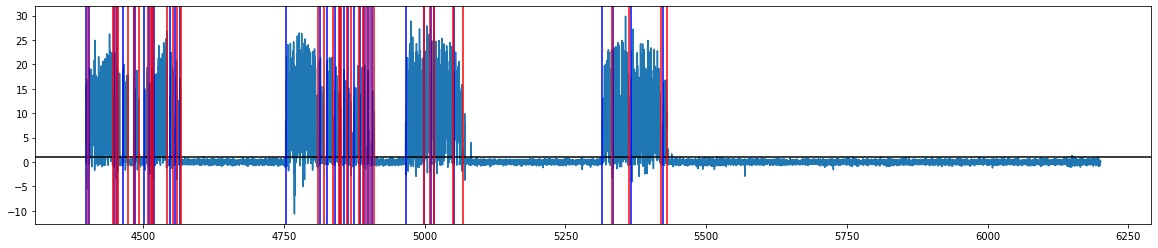

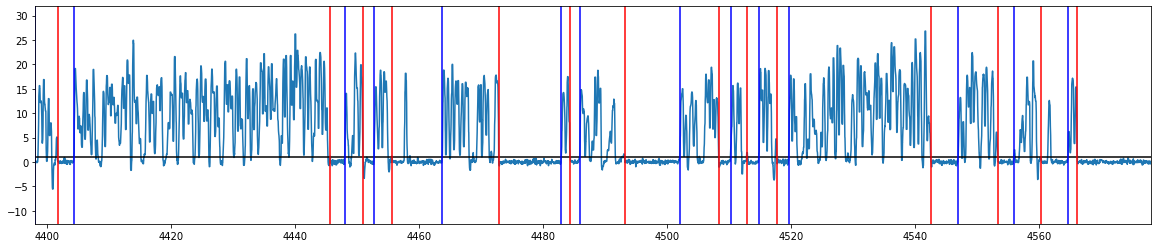

In [7]:
# drop short epochs
epochs_clean = drop_short_epochs(epochs_j, min_duration=MIN_DURATION*FS)

# plot results
plot_epochs(velocity, time, epochs_clean, threshold=1)
fig, ax = plot_epochs(velocity, time, epochs_clean, threshold=1)
ax.set_xlim([time[0], time[0]+TIME2PLOT]);


### Identify below-threshold epoch times

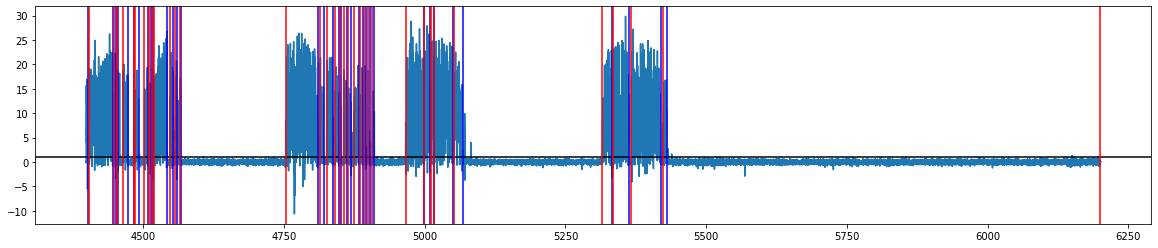

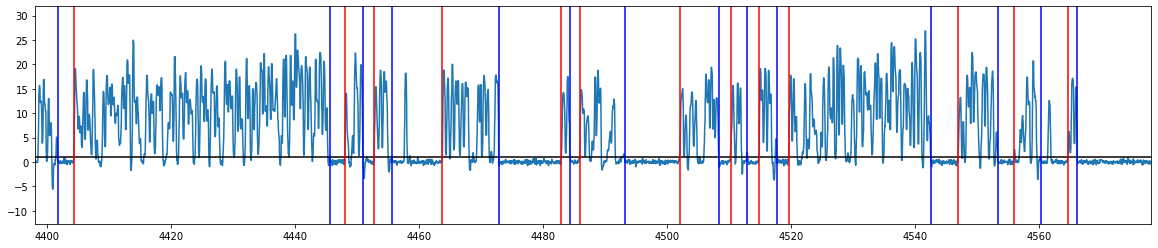

In [8]:
# get times
epochs_below = get_inverse_epochs(epochs_clean, velocity)

# plot results
plot_epochs(velocity, time, epochs_below, threshold=1)
fig, ax = plot_epochs(velocity, time, epochs_below, threshold=1)
ax.set_xlim([time[0], time[0]+TIME2PLOT]);

Dropped 0 / 35 epochs


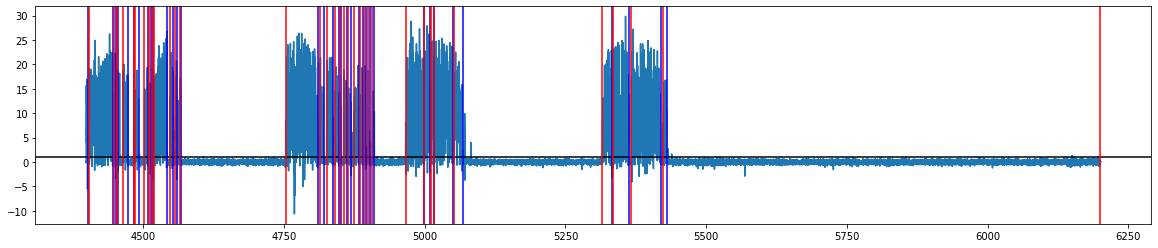

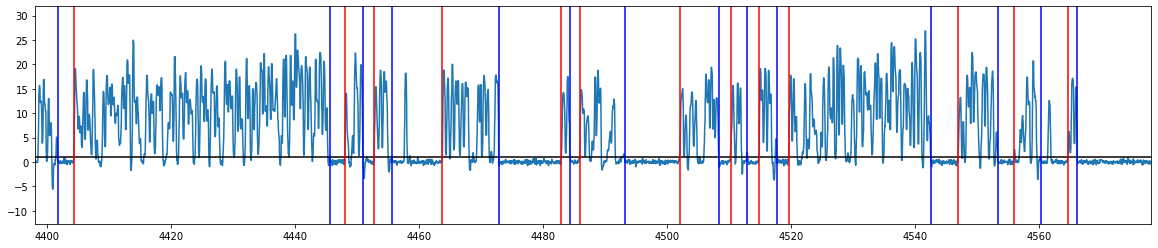

In [9]:
# drop short epochs
epochs_below_c = drop_short_epochs(epochs_below, MIN_DURATION)

# plot results
plot_epochs(velocity, time, epochs_below_c, threshold=1)
fig, ax = plot_epochs(velocity, time, epochs_below_c, threshold=1)
ax.set_xlim([time[0], time[0]+TIME2PLOT]);

### Put it all together

In [10]:
def get_epoch_times(signal, threshold, min_duration):

    # id epochs above threshold
    epochs_above = find_segments(signal, threshold=threshold, return_below=False)

    # join epochs
    epochs_above = join_epochs_with_gap(epochs_above, min_gap=min_duration)

    # drop short epochs
    epochs_above = drop_short_epochs(epochs_above, min_duration=min_duration)
    
    # if no above-threshold epochs identified
    if len(epochs_above) == 0:
        epochs_below = np.array([[0, len(signal)-1]])

    else:
        # get below-threshold epoch times
        epochs_below = get_inverse_epochs(epochs_above, signal)

        # drop short epochs
        epochs_below = drop_short_epochs(epochs_below, min_duration)

    return epochs_above, epochs_below

Identified 382 epochs
Joined 324 / 382 epochs
Dropped 11 / 58 epochs
Dropped 0 / 46 epochs


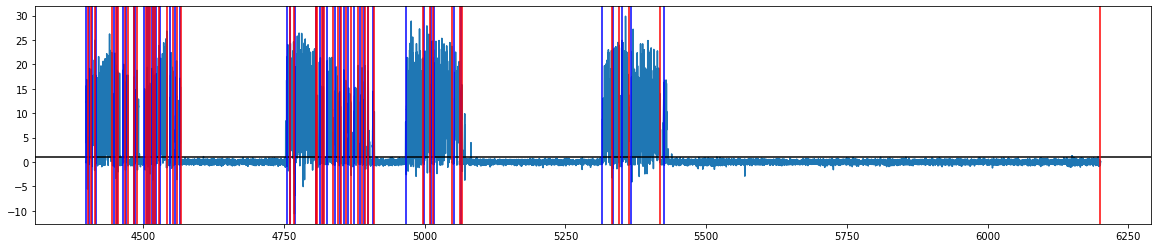

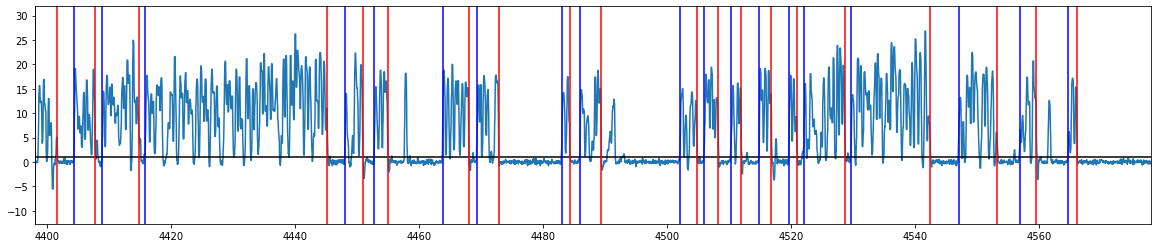

In [14]:
epochs_above, epochs_below = get_epoch_times(velocity, THRESHOLD, MIN_DURATION*FS)

# plot results
plot_epochs(velocity, time, epochs_above, threshold=1)
fig, ax = plot_epochs(velocity, time, epochs_above, threshold=1)
ax.set_xlim([time[0], time[0]+TIME2PLOT]);

### Apply to all sessions

In [15]:
# imports
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# Create Allensdk cache object
cache = EcephysProjectCache.from_warehouse(manifest=f"{MANIFEST_PATH}/manifest.json")

# load session data
sessions_all = cache.get_session_table()
session_ids = sessions_all[sessions_all['session_type']=='functional_connectivity'].index.values

In [17]:
# get epoch times for each session
epoch_times = {}

for session in session_ids:
    print(f"\nAnalyzing session: \t{session}")

    # load data
    data_in = np.load(f"{PROJECT_PATH}/data/behavior/running/running_{session}_spont.npz")
    epochs_above, epochs_below = get_epoch_times(data_in['velocity'], THRESHOLD, MIN_DURATION*FS)

    # convert to seconds
    epoch_times[f"{session}_running"] = epochs_above / FS
    epoch_times[f"{session}_stationary"] = epochs_below / FS

# save  
np.savez(f"{PROJECT_PATH}/data/behavior/running/spont_running_epochs.npz", **epoch_times)


Analyzing session: 	766640955
Identified 181 epochs
Joined 141 / 181 epochs
Dropped 11 / 40 epochs
Dropped 0 / 29 epochs

Analyzing session: 	767871931
Identified 222 epochs
Joined 204 / 222 epochs
Dropped 1 / 18 epochs
Dropped 0 / 16 epochs

Analyzing session: 	768515987
Identified 331 epochs
Joined 215 / 331 epochs
Dropped 86 / 116 epochs
Dropped 0 / 30 epochs

Analyzing session: 	771160300
Identified 382 epochs
Joined 324 / 382 epochs
Dropped 11 / 58 epochs
Dropped 0 / 46 epochs

Analyzing session: 	771990200
Identified 324 epochs
Joined 292 / 324 epochs
Dropped 5 / 32 epochs
Dropped 0 / 26 epochs

Analyzing session: 	774875821
Identified 304 epochs
Joined 261 / 304 epochs
Dropped 15 / 43 epochs
Dropped 0 / 27 epochs

Analyzing session: 	778240327
Identified 275 epochs
Joined 176 / 275 epochs
Dropped 4 / 99 epochs
Dropped 0 / 94 epochs

Analyzing session: 	778998620
Identified 156 epochs
Joined 143 / 156 epochs
Dropped 0 / 13 epochs
Dropped 0 / 12 epochs

Analyzing session: 	779839